In [1]:
import random
import numpy as np 
from functools import reduce 
import typing
from copy import deepcopy



In [2]:
from typing import Callable, Self, Union
import random

rootType = Callable[[str,str], float]
nodeType = Callable[[str], str]
leafType = str

#TODO refactor lambda functions

class SimTree():

    def __init__(self, value : leafType | nodeType | rootType = None, child : list = None):
        self.value = value 
        self.child = child or []
        self.isRoot = lambda x: True if(len(x.child) == 2) else False
        self.isNode = lambda x: True if(len(x.child) == 1) else False
        self.isLeaf = lambda x: True if(len(x.child) == 0) else False
        
    def __str__(self) -> str:
        if self.isRoot(self): #root 
            tree_list = str([self.value.__name__,
                         self.child[0].__str__(),
                         self.child[1].__str__()])
        elif self.isNode(self): #nodes
            tree_list = [self.value.__name__,self.child[0].__str__()]
        else: #leaf
            tree_list = self.value
        return tree_list  

    def __eq__(self, other : Self) -> bool:
        if self.isRoot(self) and other.isRoot(other):
            return ((self.child[0].get_depth() == other.child[0].get_depth()) and 
                    (self.child[1].get_depth() == other.child[1].get_depth())
                    ) and (self.value == other.value) and (self.child[0].__eq__(other.child[0]))
        elif self.isNode(self) and other.isNode(other):
            return (self.value == other.value) and self.child[0].__eq__(other.child[0])
        else: 
            return True
          
    def return_tree_asList(self) -> list[Union[leafType, nodeType, rootType]]:
        if self.isRoot(self): #root 
            tree_list = [self.value,
                         self.child[0].return_tree_asList(),
                         self.child[1].return_tree_asList()]
        elif self.isNode(self): #nodes
            tree_list = [self.value,self.child[0].return_tree_asList()]
        else: #leaf
            tree_list = self.value 
        return tree_list
      
    def compute(self) -> float:
        if self.isRoot(self): #root
            similarity = self.value(self.child[0].compute(),self.child[1].compute())
            return similarity
        elif self.isNode(self): #nodes
            return self.value(self.child[0].compute())
        else: #leaf
            return self.value

    def set_leaf_value(self,value : str) -> None:
        if self.isNode(self):
            self.child[0].set_leaf_value(value)
        if self.isLeaf(self):
            self.value = value

    def set_leafs_value(self,values : list[str]) -> None:
        x,y = values
        self.child[0].set_leaf_value(x)
        self.child[1].set_leaf_value(y)

    def get_Similarity_function(self) -> rootType:
        if self.isRoot(self): #root
            return self.value
        
    def get_transformations_functions(self) -> list[nodeType]:
        flatten = lambda l : [item for sublist in l for item in sublist]
        if self.isRoot(self) == 2: #root
            return flatten([self.child[0].get_transformations_functions,
                            self.child[1].get_transformations_functions])

        elif self.isNode(self) == 1: #nodes
            return self.value

    def find_depth(self,x : int) -> int:
        x+=1
        if self.isRoot(self):
            return max(self.child[0].find_depth(x), self.child[1].find_depth(x))
        if self.isNode(self):
            return self.child[0].find_depth(x)
        if self.isLeaf(self):
            return x    

    def get_depth(self) -> int:
        return self.find_depth(0)    


def tree_from_list(tree_list : list) -> SimTree:
    if len(tree_list) == 3: #root
        value = tree_list[0]
        left_child = tree_list[1]
        right_child = tree_list[2]
        return SimTree(value,
                [tree_from_list(left_child),
                tree_from_list(right_child)])
    elif len(tree_list) == 2: #nodes        
        value = tree_list[0]
        child = tree_list[1]
        return SimTree(value,[tree_from_list(child)])
    else: #leaf
        value = tree_list[0]
        return SimTree(value,[])

In [3]:
from similarity import *
from transformation import *

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Combal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Combal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Combal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
TRANSFORMATION_FUNCTIONS = transformation_functions()           
SIMILARITY_FUNCTIONS = similarity_functions()
           
flatten = lambda l : [item for sublist in l for item in sublist]
def get_rd_function(nb_child,value):
    if nb_child == 2:
        function_list = SIMILARITY_FUNCTIONS
    else:
        function_list = TRANSFORMATION_FUNCTIONS
    flag = True
    while flag:
        new_value = random.choice(function_list)
        if new_value != value:
            flag = False
    return new_value

In [5]:
from datetime import datetime

dates = [
    '2006-10-28', '2005-11-15', '1936-11-07', '1955-09-08', '1936-12-07',
    '1937-04-12', '1974-12-02', '1972-06-30', '1955-07-06', '2006-09-09',
    '2007-11-06', '2007-11-13', '2009-09-29', '2014-03-25', '2001-12-04',
    '2004-09-06', '2004-11-10', '2004-11-23', '2004-12-09', '2005-09-27',
    '2011-09-27', '2000-09-12', '1999-09-14', '2003-11-11', '2004-02-05',
    '2006-04-04', '2005-11-16', '2005-11-24', '2008-09-23', '2010-10-19',
    '2005-09-13', '2005-09-14', '2006-03-07', '2009-09-08', '2011-11-01',
    '2003-06-03', '1969-02-10', '2017-04-28', '2022-10-24', '2004-05-10',
    '2018-03-14', '2002-04-11', '2013-03-09'
]

american_dates = []
european_dates = []

for date_str in dates:
    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
    american_date = date_obj.strftime('%m/%d/%Y')
    american_dates.append(american_date)
    european_date = date_obj.strftime('%d/%m/%Y')
    european_dates.append(european_date)

# Print the converted dates
values = []
for a,e in zip(american_dates,european_dates):
    #print(a+" - "+e)
    values.append((a,e))


In [33]:
class SimGen():
    def __init__(self, param_algo : dict , param_data : dict):
        #main param
        self.population_size : int = param_algo["population_size"]
        self.nb_generation   : int = param_algo["nb_generation"]
        
        
        #evolution param
        self.proba_mutation  : float = param_algo["proba_mutation"]
        self.proba_crossover : float = param_algo["proba_crossover"]
        self.proba_random_tree : float = param_algo["proba_random"]
        self.mutation_population_size    : int = round(self.proba_mutation*self.population_size)
        self.crossover_population_size   : int = round(self.proba_crossover*self.population_size)
        self.random_tree_population_size : int = round(self.proba_random_tree*self.population_size)
        self.elitism_population_size     : int = self.population_size - (
            self.mutation_population_size+
            self.crossover_population_size+
            self.random_tree_population_size
        )
        #self.proba_ellitism  : float = param_algo["proba_ellitism"] #proba to keep best elem

        #candidate param
        self.tree_max_depth : int = param_data["tree_max_depth"]

        #init param
        #TODO implement diff types of population in evolution
        self.population : list[SimTree] = [] #current population
        self.population_new : list[SimTree] = [] #previous population
        self.population_scores : list[int] = [0]*self.population_size #every candidate has a score computed at the end of an generation
        self.similarity_functions : list[rootType] = param_data["similarity_functions"] 
        self.transformation_functions : list[nodeType] = param_data["transformation_functions"]

        #values param
        self.values : list[tuple[str,str]] = param_data["values"] #[(x1,y1),(x2,y2)...,(xn,yn)] such as (ei,p,xi) <=> (e'i,p',yi)

        #meta param
        self.gen_scores = []
    def generate_random_tree(self):
        nb_transformation = random.randint(1,self.tree_max_depth)
        tf_left = np.random.choice(self.transformation_functions,nb_transformation,replace=False)
        tf_left = np.append(tf_left,["a"]) #TODO check comment mieux gerer le lift
        tf_right = np.random.choice(self.transformation_functions,nb_transformation,replace=False)
        tf_right = np.append(tf_right,["a"])
        sf = np.random.choice(self.similarity_functions,1)[0]
        def nest_list(lst):
            #format our list of function : [f,g,h,...]
            #into : [f,[g,[h,[...]]]]
            if len(lst) == 1:
                return [lst[0]]
            else:
                return [lst[0], nest_list(lst[1:])]

        tree_list = [sf,nest_list(tf_left),nest_list(tf_right)]
        tree = tree_from_list(tree_list)
        return tree

    def init_population(self):
        """
            Generate a population of size n with random tree
        
        """
        #check variance and stuff meta data TODO
        for _ in range(self.population_size):
            self.population.append(self.generate_random_tree())
    
    #TODO add regularisation parameter
    def fitness_function(self):
        '''
            Compute the score of a tree on every value pair
            Keep the mean as a score
        '''    
         
        for index,candidate in enumerate(self.population):
            sim_score = 0
            for values in self.values:
                #compute score for each value pair for one tree
                candidate.set_leafs_value(values)
                score = candidate.compute()
                sim_score += score
            sim_score /= len(self.values)
            #depth scoring
            min_depth = 3
            depth_score = (self.tree_max_depth - min_depth)/self.population[index].get_depth()
            alpha = 0.5
            self.population_scores[index] = sim_score - (alpha*depth_score)
            
            if self.population_scores[index] > 1:
                self.population_scores[index] = 1
            if self.population_scores[index] < 0:
                self.population_scores[index] = 0
                
                
            
    #TODO add loger to track evolution change
    def mutation(self):
        mutation_candiate = np.random.choice(self.population,self.mutation_population_size,replace=True).copy()
        n=0
        for candidate in mutation_candiate:
            root_pointer = deepcopy(candidate)
            tree = root_pointer
            invalid_mutation = True
            while invalid_mutation:
                mutation_type = np.random.choice(["add","modify","remove"])
                if mutation_type =="remove":
                    #if condition not correct we loop because we cannot remove every transformation function
                    invalid_mutation = tree.child[0].get_depth() <= 2 or tree.child[1].get_depth() <= 2
                else: 
                    invalid_mutation = False
            match mutation_type:
                case "modify":
                    if np.random.choice(['root','nodes']) == 'nodes':
                        #print("change node")
                        tree = np.random.choice(tree.child) #choose left or right branche
                        max_depth = tree.get_depth() - 1 #minus leaf, 0 is current node, 1 is next node ... etc
                        depth_choice = np.random.choice(max_depth,1)[0]
                        while depth_choice > 0:
                            tree = tree.child[0]
                            depth_choice -=1
                        #depth_choice should be 0
                    #else:
                        #print("change root")
                    tree.value = get_rd_function(len(tree.child),tree.value)

                case "add":
                    child_choice = np.random.choice([0,1]) #choose left or right branche
                    tree = tree.child[child_choice]
                    max_depth = tree.get_depth()
                    target_depth = np.random.choice(max_depth,1)[0]
                    #print("target_depth",target_depth)
                    #print("max depth", tree.get_depth())
                    before = 0 #we need to insert a node before the current one, i.e : a new node conected to the root
                    after  = 1 # we keep track of depths, we stop if we find our target depth
                    while before != target_depth and after != target_depth: #if after find target or before already is target
                        tree = tree.child[0]
                        after  += 1
                    #we found our target depth
                    #print(f"after : {after}, before {before}")
                    if before == target_depth: #we need to add a node connected to the root
                        _tmp = root_pointer.child[child_choice]
                        root_pointer.child[child_choice] = SimTree(get_rd_function(len(_tmp.child),None), [_tmp])
                    if after == target_depth: #we add a new node after the current
                        _tmp = tree.child[0]
                        tree.child[0] = SimTree(get_rd_function(len(_tmp.child),None),[_tmp])

                case "remove":
                    child_choice = np.random.choice([0,1]) #choose left or right branche
                    #print(f"child choice : {'left' if child_choice else 'right'}")
                    before_pointer = tree
                    tree = tree.child[child_choice]
                    max_depth = tree.get_depth() - 1
                    target_depth = np.random.choice(max_depth,1)[0]
                    while target_depth != 0:
                        before_pointer = tree
                        tree = tree.child[0]
                        target_depth -=1
                    #we found our target depth
                    #print(f"target_depth : {target_depth}")
                    #link previous child we after child
                    before_pointer.child[0] = tree.child[0]
            n+=1
            self.population_new.append(root_pointer) #append new created element

    #TODO if odd number, last index tuple will contain same index twice 
    def crossover(self):
        n =0
        #TODO ajouter où les nouveaux arbres
        crossover_candidates = zip(
            (candidate_list := np.random.choice(self.population,(self.crossover_population_size*2)+1,replace=False))[0:self.crossover_population_size],
            candidate_list[self.crossover_population_size+1:])
        for t1,t2 in crossover_candidates:
            node_choice = [
                [deepcopy(t1.child[0]), deepcopy(t2.child[1])],
                [deepcopy(t2.child[0]), deepcopy(t1.child[1])],
            ]
            new_root_value = np.random.choice([t1.value,t2.value])
            new_tree = SimTree(new_root_value,node_choice[np.random.choice(2)])
            n+=1
            self.population_new.append(new_tree)
        
    def elitism(self):

        #select best individuals
        score_index = list(np.argsort(self.population_scores))
        score_index.reverse()
        #elitism population
        best_individuals = deepcopy([self.population[index] for index in score_index[0:self.elitism_population_size]])
        #remove best elem from population
        self.population_new = np.append(self.population_new,best_individuals).tolist()
        #mutation population

    def random_selection(self):
        n = 0
        for tree in np.random.choice(self.population,self.random_tree_population_size):
            self.population_new.append(deepcopy(tree))       
            n+=1
    def save_state(self):
        pass

    def load_state(self):
        pass

    def evolve_population(self, load= False):
        #compute score for each tree
        self.init_population()
        if load:
            self.load_state()
        for _ in range(self.nb_generation):
            self.save_state()
            self.fitness_function()
            self.mutation()
            self.crossover()
            self.random_selection()
            self.elitism()
            self.population = self.population_new
            self.population_new = []
            self.gen_scores.append(deepcopy(self.population_scores))
 
        self.fitness_function()
        self.gen_scores.append(self.population_scores)
            
     
    #TODO crossover
    #TODO add log to show trace of evolution for candidates
    #TODO implement duel for elitism
    #TODO add meta analyse de la taille des arbres et des types de fonctions utilisées
    #TODO maybe add constraint to force each operation to take new elem, (just check with index)

In [34]:
param_algo = {
    "population_size" : 100,
    "nb_generation"   : 50,
    "proba_mutation"  : 0.4,
    "proba_crossover" : 0.2,
    "proba_random"    : 0.1,
    #"proba_ellitism"  : 0.4
}

param_data = {
    "tree_max_depth" : 8,
    "similarity_functions" : similarity_functions(),
    "transformation_functions" : transformation_functions(),
    "values" : values
}


sim = SimGen(param_algo,param_data)
sim.evolve_population()

In [8]:
(index := list(np.argsort(sim.population_scores))).reverse()
for i in index:
    print(sim.population_scores[i],sim.population[i])


0.7727272727272727 ['jaccard_similarity', ['uppercase', ['flatten', ['remove_whitespace', ['stem', ['remove_punctuation', ['remove_stopwords', ['lowercase', ['tokenize', ['lowercase', '03/09/2013']]]]]]]]], ['strip_whitespace', ['remove_whitespace', ['lowercase', ['flatten', ['tokenize', ['lowercase', ['uppercase', ['remove_punctuation', '09/03/2013']]]]]]]]]
0.7727272727272727 ['jaccard_similarity', ['uppercase', ['flatten', ['remove_whitespace', ['stem', ['tokenize', ['remove_punctuation', ['remove_stopwords', ['tokenize', ['lowercase', '03/09/2013']]]]]]]]], ['strip_whitespace', ['remove_whitespace', ['lowercase', ['flatten', ['tokenize', ['remove_stopwords', ['uppercase', ['remove_punctuation', '09/03/2013']]]]]]]]]
0.7727272727272727 ['jaccard_similarity', ['uppercase', ['flatten', ['remove_whitespace', ['stem', ['tokenize', ['remove_punctuation', ['remove_stopwords', ['tokenize', ['lowercase', '03/09/2013']]]]]]]]], ['strip_whitespace', ['tokenize', ['remove_whitespace', ['lowerc

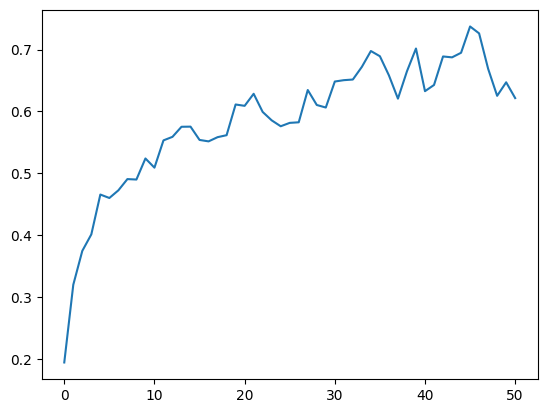

In [37]:
import matplotlib.pyplot as plt
pop_scores  = [np.mean(x) for x in sim.gen_scores]
plt.plot(np.arange(0,len(pop_scores),1),pop_scores)

In [16]:
sim.fitness_function()


In [17]:
print_pop = list(map(lambda x: str(x),sim.population))

In [18]:
###---------------------------------------------------------------------###
###-------------------------------------> Helper functions

def f(a : str) -> str:
    return a+"o"
def g(a : str) -> str:
    return a+"K"
def h(a : str) -> str:
    return a+a
def ag1(a : str, b : str) -> str:
    return a+"-"+b
def ag2(a : str, b : str) -> str:
    return b+"-"+a



In [19]:
a = [ag1,[g,"a"],[g,[g,[g,["b"]]]]]
b = [ag1,[f,[g,"b"]],[g,[g,[g,["b"]]]]]
tree = tree_from_list(a)
tr = tree_from_list(b)
tr.get_depth()

5

In [20]:
np.linspace(3,8,4)

array([3.        , 4.66666667, 6.33333333, 8.        ])

In [21]:
addresses = [
    '1234 Elm Street',
    '567 Maple Avenue',
    '789 Oak Drive',
    '1011 Pine Lane',
    '1213 Cedar Court',
    '1415 Birch Road',
    '1617 Willow Way',
    '1819 Aspen Circle',
    '2021 Juniper Street',
    '2223 Spruce Avenue',
    '2425 Alder Drive',
    '2627 Chestnut Lane',
    '2829 Poplar Court',
    '3031 Magnolia Road',
    '3233 Laurel Way',
    '3435 Acacia Circle',
    '3637 Sycamore Street',
    '3839 Hickory Avenue',
    '4041 Pinecone Drive',
    '4243 Cedar Lane',
    '4445 Birch Court',
    '4647 Willow Road',
    '4849 Aspen Way',
    '5051 Juniper Avenue',
    '5253 Spruce Drive',
    '5455 Alder Court',
    '5657 Chestnut Street',
    '5859 Poplar Avenue',
    '6061 Magnolia Lane',
    '6263 Laurel Circle',
    '6465 Acacia Road',
    '6667 Sycamore Way',
    '6869 Hickory Court',
    '7071 Pinecone Street',
    '7273 Cedar Avenue',
    '7475 Birch Drive',
    '7677 Willow Lane',
    '7879 Aspen Court',
    '8081 Juniper Road',
    '8283 Spruce Way',
    '8485 Alder Circle',
    '8687 Chestnut Avenue',
    '8889 Poplar Drive',
    '9091 Magnolia Court',
    '9293 Laurel Street',
    '9495 Acacia Lane',
    '9697 Sycamore Avenue',
    '9899 Hickory Road',
    '100101 Pinecone Way',
    '102103 Cedar Court'
]
import random

def add_noise(address):
    address_parts = address.split()
    for i in range(len(address_parts)):
        part = address_parts[i]
        if part.isdigit():
            # Modify the numbers by adding or subtracting a small random value
            num = int(part)
            noise = random.randint(-5, 5)
            address_parts[i] = str(num + noise)
        else:
            # Modify the names by randomly replacing a character with another
            modified_part = ''
            for char in part:
                if random.random() < 0.1:  # 10% chance of modification
                    modified_part += random.choice('abcdefghijklmnopqrstuvwxyz')
                else:
                    modified_part += char
            address_parts[i] = modified_part
    return ' '.join(address_parts)

noisy_addresses = [add_noise(address) for address in addresses]



In [22]:
param_algo = {
    "population_size" : 100,
    "nb_generation"   : 10,
    "proba_mutation"  : 0.3,
    "proba_crossover" : 0.2,
    "proba_random"    : 0.1,
    #"proba_ellitism"  : 0.4
}

param_data = {
    "tree_max_depth" : 8,
    "similarity_functions" : similarity_functions(),
    "transformation_functions" : transformation_functions(),
    "values" : values
}
# Print the converted dates
values = []
for a,e in zip(noisy_addresses,addresses):
    #print(a+" - "+e)
    values.append((a,e))


sim = SimGen(param_algo,param_data)
sim.evolve_population()


In [23]:
for i,v in enumerate(sim.population_scores):
    if v> 0.9 :
        print(sim.population[i])